(Example from the Book p.29 ff)

A lighthouse is somewhere off a piece of straight coastline at a position $\alpha$ (alpha) along the shore and a distance <br>
$\beta$ (beta) out at sea. It emits a series of short highly collimated flashes at random intervals and hence at random azimuths, $\theta$. <br>
These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not <br>
the angle from which it came. <br>
N flashes have so far been recorded at positions $\{x_k\}$. Where is the lighthouse?’

<img src="pictures01/lightHouseGeometry.jpg">

If we assume a uniform distribution, $ prob(\theta | \{x_k\}, \alpha, \beta, I) = \frac{1}{\pi}$ for $\theta$ between $[- \pi/2 , + \pi/2]$, we get a Cauchy-Distribution for the $x_k$ :

$$
prob(x_k | \alpha, \beta, I) = \frac{\beta}{\pi [\beta^2 + (x_k - \alpha)^2]}
$$

Using Bayes' theorem and assuming independence of the measurements, the log-prob function L is given by:

$$
  L = log(prob(  \alpha, \beta | \{x_k\} , I) = const + \sum^N_{k=1}{(log(\beta) - log(\beta^2 + (x_k - \alpha)^2))}
$$

Our best estimate for $\alpha$ and $\beta$ are the values that maximize the log-prob function L.
We can take the partial derivatives of L for $\alpha$ and $\beta$ and set them equal to zero and solve the equations numerically. Or we use gradient descent to find the minimum of -L, i.e. the maximum of L.
Thus we end up with a non-liniear optimization problem / non-linear root finding problem that we will have to solve numerically:

$$
\frac{\partial L}{\partial \alpha} = \sum^N_{k=1}{\frac{2 (x_k - \alpha)}{\beta^2 + (x_k - \alpha)^2}} = 0 \\


\frac{\partial L}{\partial \beta} = \frac{N}{\beta} - \sum^N_{k=1}{\frac{2 \beta}{\beta^2 + (x_k - \alpha)^2}} = 0
$$

In [9]:
# define a function that generates the data we want to use:

import numpy as np

a = 1       # on shore position of Lighthouse
b = 2       # off shore position of Lighthouse
N = 10      # number of datapoints /measurements to generate

def generate_x_ks(a, b, N=10):
    thetas = np.random.uniform(low= - np.pi * 0.5, high= np.pi * 0.5, size=(1,N))
    x_ks = a + b * np.tan(thetas)
    return x_ks

# test:
generate_x_ks(a, b, N)

array([[  3.88689581,   3.26370043,   1.36051519,   0.53173531,
         -0.52151401,   0.65913569,   1.70895004,   0.40935226,
        -15.8044739 ,   1.5447968 ]])

In [10]:
# define a function that gives back the partial derivative of L after a(lpha) as a function of a and b(eta):

def grad_L_a(x_ks):
    def grad(a, b):
        diffs = x_ks - a
        numerator = diffs
        denominator = b**2 + diffs**2
        fractions = numerator/denominator
        return 2 * np.sum(fractions)  
    return grad

# test:
a = 1
b = 2
x_ks = generate_x_ks(a,b)

dLa = grad_L_a(x_ks)
dLa(5, b)

-2.303835148863117

In [11]:
# define a function that gives back the partial derivative of L after b as a function of a and b:
def grad_L_b(x_ks):
    def grad(a, b):
        N = np.size(x_ks)
        diffs = x_ks - a
        numerator = b
        denominator = b**2 + diffs**2
        fractions = numerator/denominator
        return (N/b) - 2 * np.sum(fractions)  
    return grad

# test:
a = 1
b = 2
x_ks = generate_x_ks(a,b)
dLb = grad_L_b(x_ks)
dLb(a, b)

0.27999940410352764

In [12]:
# implement gradient descent to find the maximum of L, i.e. the minimum of -L:

def gradient_descent(x, y, x_ks, learning_rate=0.01, N_iterations=1000):
    # y is the strarting-point for the off-shore distance - hence allways positive:
    if y < 0 or y==0:
        return
    dL_da = grad_L_a(x_ks)
    dL_db = grad_L_b(x_ks)
    for _ in np.arange(N_iterations):
        x_old = x
        x = x + learning_rate * dL_da(x, y) # plus learningrate * ... is correct in this case, because we find the minimum of -L
        y = y + learning_rate * dL_db(x_old, y)
    return x,y

# test:
""" a = 11
b = 2
x_ks = generate_x_ks(a, b, 100)
gradient_descent(43, 7, x_ks) """

' a = 11\nb = 2\nx_ks = generate_x_ks(a, b, 100)\ngradient_descent(43, 7, x_ks) '

### Additonal things to do:
- plot graphs of $prob(\alpha | \{x_k\}, I)$ and $prob(\beta | \{x_k\}, I)$
- add (Gaussian) noise to the problem - either in $\theta$ or in $x_k$
- calculate error-bars for $\alpha$ and $\beta$ and the correlation-matrix
- solve the problem by calculating the zeros of the partial derivatives (i.e. a different algorithm)
- plot a sequence of graphs showing the successive approximation of the estimated location and the real location of the light-house. Add 90% prob-contours to the plot
- make the sequence of plots an animation

We want to plot the distributions of $\alpha$ and $\beta$. To that end we try to calculate the marginal distribution $prob(\alpha|\{x_k\},I)$ by calculating the integral over $\beta$ of $prob(  \alpha, \beta | \{x_k\} , I)$ by summation. <br>
Using Bayes as usual we calculate with <br>
$$
prob(x_k | \alpha, \beta, I) = \frac{\beta}{\pi [\beta^2 + (x_k - \alpha)^2]}
$$ 
instead of
$$
prob(  \alpha, \beta | \{x_k\} , I)
$$
The list prob_a is the list of the values of the marginal distribution evaluated on the points of alpha_range. <br>
<br>
There is a problem though, as one can see, when executing the code in the next cells: the product of the probabilities $prob(x_k| \alpha,\beta,I)$ becomes very small the more datapoints $x_k$, we have, since all these probabilities are smaller then one. That's why I tried to sum over the logs of those probabilites - which does not help either... <br>
So I am in need of some scaling here. Ironically I by dropping the normalization of the distributions, I dropped the scaling...<br>
On the other handside - I just want to plot the graphs, I do not need the exact probabilities.

Using Bayes' theorem and assuming independence of the measurements, the log-prob function L is given by:

$$
  L = log(prob(  \alpha, \beta | \{x_k\} , I) = const + \sum^N_{k=1}{(log(\beta) - log(\beta^2 + (x_k - \alpha)^2))}
$$

In [13]:
def log_prob_Xk_g_a_b_I(x_ks):
    # returns a function log-prob(alpha,beta)
    # which is the log of the prob of X_k given alpha, beta, I up to a constant 
    # - as a function of alpha and beta

    def log_prob(alpha, beta):
        N = x_ks.shape[0]
        #print(f"N={N}")
        diffs = x_ks - alpha
        #print(f"diffs**2={diffs**2}")
        return N * np.log(beta) - np.sum(np.log(beta**2 + diffs**2))
    return log_prob

# test:
""" x_ks = np.array([1,2,3])
log_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)
a = 1
b = np.e
log_prob(a,b) """



' x_ks = np.array([1,2,3])\nlog_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)\na = 1\nb = np.e\nlog_prob(a,b) '

In [21]:
# try to calculate the marginal distribution prob(a|{x_k},I) - calculating the integral over b of prob(a,b|{x_k}, I) by sums
# prob_a is the list of the values of the marginal distribution of a evaluated on the points of alpha_range.
#
# There is a problem though: the product of the probabilities prob({x_k}| a,b,I) becomes very small the more datapoints, x_k, we have...

alpha_range = np.linspace(-20, 20, num=1000, retstep=True)
beta_range = np.linspace(0, 10, num=100, retstep=True) # returns (samples, spacing between samples)

# integration by summation:
a = 5
b = 4
x_ks = generate_x_ks(a, b, 100)
log_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)

prob_a = []
db = beta_range[1]
for alpha in alpha_range[0]:
    prob_beta = 0.0
    for beta in beta_range[0]:
        prob_beta = prob_beta + np.exp(log_prob(alpha,beta)) * db
    
    #print(f"probs:{prob_beta}")
    prob_a.append(prob_beta)

# this is the scaling I try:
max_prob_a = max(prob_a)
scaled_probs_a = np.array(prob_a)/max_prob_a

# test:
#scaled_probs_a

# in the analogous way try to calculate the marginal distribution prob(b|{x_k},I) - calculating the integral over a of prob(a,b|{x_k}, I) by sums
# prob_b is the list of the values of the marginal distribution of b evaluated on the points of beta_range.

prob_b = []
da = alpha_range[1]
for beta in beta_range[0]:
    prob_alpha = 0.0
    for alpha in alpha_range[0]:
        prob_alpha = prob_alpha + np.exp(log_prob(alpha,beta)) * da
    
    #print(f"prob_alpha:{prob_alpha}")
    prob_b.append(prob_alpha)

# this is the scaling I try:
max_prob = max(prob_b) 
scaled_probs_b = np.array(prob_b)/max_prob





C:\Users\Hal9\AppData\Local\Temp\ipykernel_11028\3938957500.py:11: RuntimeWarning: divide by zero encountered in log
  return N * np.log(beta) - np.sum(np.log(beta**2 + diffs**2))


In [22]:
# try to calculate the marginal distribution prob(b|{x_k},I) - calculating the integral over a of prob(a,b|{x_k}, I) by sums
# prob_b is the list of the values of the marginal distribution of b evaluated on the points of beta_range.

prob_b = []
da = alpha_range[1]
for beta in beta_range[0]:
    prob_alpha = 0.0
    for alpha in alpha_range[0]:
        prob_alpha = prob_alpha + np.exp(log_prob(alpha,beta)) * da
    
    #print(f"prob_alpha:{prob_alpha}")
    prob_b.append(prob_alpha)

# this is the scaling I try:
max_prob = max(prob_b) 
scaled_probs_b = np.array(prob_b)/max_prob

C:\Users\Hal9\AppData\Local\Temp\ipykernel_11028\3938957500.py:11: RuntimeWarning: divide by zero encountered in log
  return N * np.log(beta) - np.sum(np.log(beta**2 + diffs**2))


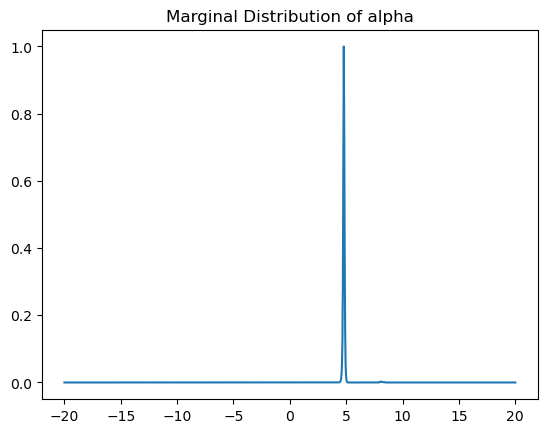

In [23]:
import matplotlib.pyplot as plt

plt.title("Marginal Distribution of alpha")
plt.plot(alpha_range[0], scaled_probs_a)
plt.show()


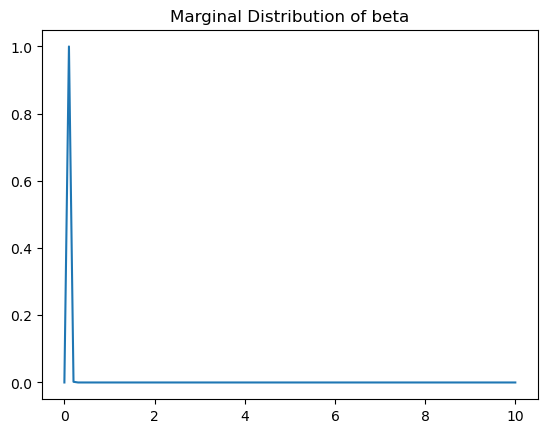

In [24]:
plt.title("Marginal Distribution of beta")
plt.plot(beta_range[0], scaled_probs_b)
plt.show()

# It looks as if I missed something for the marginal distribution of beta